In [1]:
import os
import sys
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as tf

base_dir = os.path.dirname(os.getcwd())
sys.path.append(base_dir)

from src import Digit, Product, TSDataset, TimeSerie
from src.utils import list_collate

### Setup MNIST and TS Datasets

In [3]:
# MNIST
batch_size = 512
data_path = "../data/mnist"

mnist = MNIST(root=data_path, train=True)
dataloader = DataLoader(dataset=mnist,
                        batch_size=batch_size,
                        collate_fn=list_collate)

mnist

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../../../../Documents/Programming/torchsession/test/
    Split: Train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dim_0   128 non-null    object
 1   dim_1   128 non-null    object
 2   dim_2   128 non-null    object
dtypes: object(3)
memory usage: 3.1+ KB



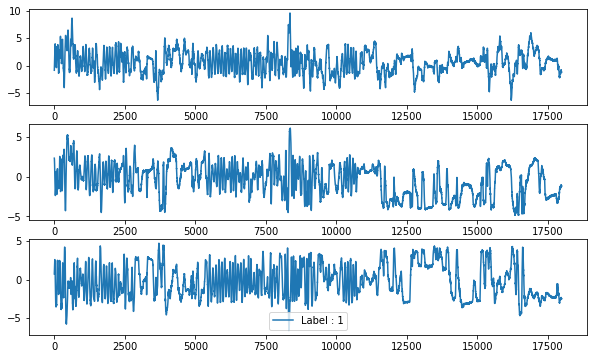

In [4]:
# Time Serie
root = '../data/ts/Multivariate_ts/EigenWorms/EigenWorms_TRAIN.ts'
ts_dataset = TSDataset(root=root)

# Hardset the number of dimension to 3 to allow RGB visualization of product
ts_dataset._data = ts_dataset._data[['dim_0', 'dim_1', 'dim_2']]

print(ts_dataset)
ts_dataset.plot(0)

### Define digits transform

In [5]:
# Define digits transforms
digit_transform = tf.Compose([tf.RandomAffine(degrees=(-90, 90),
                                              scale=(0.5, 1),
                                              shear=(-1, 1)),
                              tf.RandomChoice([tf.RandomHorizontalFlip(0.5),
                                               tf.RandomVerticalFlip(0.5)]),
                              tf.RandomPerspective()])

### Instantiate product

In [6]:
# Instantiate product
product_kwargs = {'size': (300, 300),
                  'nbands': 3,
                  'horizon': 20,
                  'grid_size': (17, 17),
                  'color': 0,
                  'mode': 'grid',
                  'rdm_dist': lambda *args, **kwargs: 2 * np.random.randn(*args, **kwargs),
                  'blob_transform': digit_transform}

product = Product(**product_kwargs)
product

{}

----

### Register batch of digits to product
__(should yield StopIteration exception because `batch_size` > #availableGridSlots)__

In [7]:
digits, _ = iter(dataloader).next()

In [8]:
for img in digits:
    # Draw random time serie from dataset
    ts, label = ts_dataset.choice()
    # Create time serie instance with same or greater horizon 
    time_serie = TimeSerie(ts, label, horizon=product.horizon)
    # Encapsulate at digit level
    d = Digit(img, label=label, time_serie=time_serie)
    product.random_register(d)

IndexError: No space left on grid

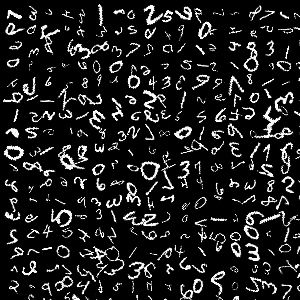

In [9]:
# Greyscale glimpse of product
product.view()

In [10]:
# Generate view for each time step and save them somewhere
# From command line, you should see a progress bar while generating
output_dir = "../sandbox/outputs/"
product.generate(output_dir=output_dir, astype='jpg')

---